# Face detection and cropping


In [29]:
import dlib
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

In [30]:
def detect_faces(image):
    face_detector = dlib.get_frontal_face_detector()

    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

In [31]:
def crop_faces_with_padding(image, face_rects, padding=20):
    cropped_faces = []
    for face_rect in face_rects:
        left, top, right, bottom = face_rect

        left = max(0, left - padding)
        top = max(0, top - padding - 10)
        right = min(image.shape[1], right + padding)
        bottom = min(image.shape[0], bottom + padding)

        face = Image.fromarray(image).crop((left, top, right, bottom))
        cropped_faces.append(face)

    return cropped_faces

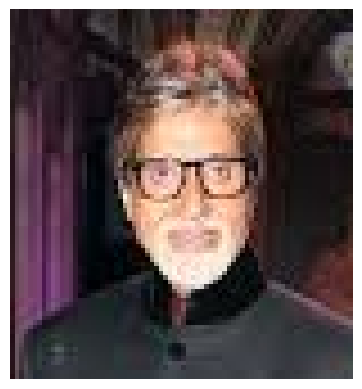

In [36]:
img_path = '/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Dress/amitabh_bachchan/download (1).jpeg'
image = io.imread(img_path)

detected_faces = detect_faces(image)
cropped_faces = crop_faces_with_padding(image, detected_faces)

# # Save cropped faces
# for n, face in enumerate(cropped_faces):
#     face.save(img_path + '_cropped_face.jpg', 'JPEG')

# Plot the cropped faces
for n, face in enumerate(cropped_faces):
    plt.subplot(1, len(cropped_faces), n + 1)
    plt.axis('off')
    plt.imshow(face)

plt.show()

# Recommendor

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from scipy.spatial.distance import cosine
import pickle
import dlib
from PIL import Image
import os
from tqdm import tqdm

In [63]:
def load_model(file_path):
    model = tf.keras.models.load_model(file_path)
    layer_name = model.layers[-2].name
    embedding_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    return embedding_model, model

In [10]:
img_size = (200, 200)
face_embedding_model, face_predict_model = load_model('/content/celeb_face_cnn_model.h5')
body_embedding_model, body_predict_model = load_model('/content/body_shape_cnn_model.h5')

In [57]:
class CelebrityMatchingSystem:
    def __init__(self, face_model, body_model, img_size):
        self.face_model = face_model
        self.body_model = body_model
        self.img_size = img_size
        self.stored_face_embeddings = []
        self.stored_body_embeddings = []
        self.celebrity_data = []
        self.face_detector = dlib.get_frontal_face_detector()

    def preprocess_image(self, image_path):
        img = load_img(image_path, target_size=self.img_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array

    def detect_and_crop_face(self, image_path, padding=20):
        image = np.array(Image.open(image_path))

        detected_faces = self.face_detector(image, 1)
        if not detected_faces:
            return None

        face = detected_faces[0]

        left = max(0, face.left() - padding)
        top = max(0, face.top() - padding - 10)
        right = min(image.shape[1], face.right() + padding)
        bottom = min(image.shape[0], face.bottom() + padding)

        face_image = Image.fromarray(image).crop((left, top, right, bottom))

        face_image = face_image.resize(self.img_size[:2])
        face_array = img_to_array(face_image)
        face_array = np.expand_dims(face_array, axis=0) / 255.0

        return face_array

    def add_celebrity(self, image_path, name):
        face_array = self.detect_and_crop_face(image_path)
        if face_array is None:
            return

        body_array = self.preprocess_image(image_path)

        face_embedding = self.face_model.predict(face_array)
        body_embedding = self.body_model.predict(body_array)

        self.stored_face_embeddings.append(face_embedding)
        self.stored_body_embeddings.append(body_embedding)
        self.celebrity_data.append((image_path, name))

    def find_matches(self, query_image_path, top_k=3, face_weight=0.5):
        # Extract face features
        query_face_array = self.detect_and_crop_face(query_image_path)
        if query_face_array is None:
            print("No face detected in the input image.")
            return

        query_face_embedding = self.face_model.predict(query_face_array)

        # Extract body features
        query_body_array = self.preprocess_image(query_image_path)
        query_body_embedding = self.body_model.predict(query_body_array)

        distances = []
        for idx, (face_emb, body_emb) in enumerate(zip(self.stored_face_embeddings, self.stored_body_embeddings)):
            face_distance = cosine(query_face_embedding.flatten(), face_emb.flatten())
            body_distance = cosine(query_body_embedding.flatten(), body_emb.flatten())
            combined_distance = face_weight * face_distance + (1 - face_weight) * body_distance
            distances.append((idx, combined_distance, face_distance, body_distance))

        top_matches = sorted(distances, key=lambda x: x[1])[:top_k]

        detailed_matches = []
        for idx, combined_distance, face_distance, body_distance in top_matches:
            image_path, name = self.celebrity_data[idx]
            match_info = {
                "name": name,
                "image_path": image_path,
                "combined_distance": combined_distance,
                "face_distance": face_distance,
                "body_distance": body_distance
            }
            detailed_matches.append(match_info)

        return detailed_matches

In [17]:
def load_celebrity_dataset(dataset_path):
    celebrities = []
    for celebrity_name in os.listdir(dataset_path):
        celebrity_folder = os.path.join(dataset_path, celebrity_name)
        if os.path.isdir(celebrity_folder):
            for image_name in os.listdir(celebrity_folder):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(celebrity_folder, image_name)
                    celebrities.append((image_path, celebrity_name))
    return celebrities

In [25]:
matching_system = CelebrityMatchingSystem(face_embedding_model, body_embedding_model, img_size)

dataset_path = '/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Dress'
celebrities = load_celebrity_dataset(dataset_path)

print(f"Loading {len(celebrities)} celebrity images...")
for image_path, celebrity_name in tqdm(celebrities):
    matching_system.add_celebrity(image_path, celebrity_name)

Loading 124 celebrity images...


  0%|          | 0/124 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  1%|          | 1/124 [00:00<01:42,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▏         | 2/124 [00:01<01:07,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 3/124 [00:01<01:00,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 4/124 [00:02<01:13,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  4%|▍         | 5/124 [00:03<01:12,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  5%|▍         | 6/124 [00:03<00:57,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  6%|▌         | 7/124 [00:03<00:51,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  6%|▋         | 8/124 [00:03<00:47,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  7%|▋         | 9/124 [00:04<00:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  8%|▊         | 10/124 [00:04<00:43,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  9%|▉         | 11/124 [00:05<00:49,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 10%|▉         | 12/124 [00:05<00:42,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 13/124 [00:06<01:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█▏        | 14/124 [00:07<01:04,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 15/124 [00:07<00:52,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 13%|█▎        | 16/124 [00:07<00:50,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 14%|█▎        | 17/124 [00:08<00:58,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 15%|█▍        | 18/124 [00:08<00:48,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|█▌        | 19/124 [00:09<00:53,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 16%|█▌        | 20/124 [00:09<00:44,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 21/124 [00:09<00:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 18%|█▊        | 22/124 [00:10<00:41,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▊        | 23/124 [00:10<00:42,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 24/124 [00:11<00:39,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 27/124 [00:12<00:27,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 23%|██▎       | 28/124 [00:12<00:36,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 31/124 [00:13<00:22,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 26%|██▌       | 32/124 [00:14<00:42,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 33/124 [00:14<00:39,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 34/124 [00:15<00:53,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 35/124 [00:16<01:00,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 36/124 [00:17<00:51,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|██▉       | 37/124 [00:17<00:52,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 38/124 [00:18<01:07,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 40/124 [00:19<00:53,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▎     | 54/124 [00:20<00:06, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|████▌     | 56/124 [00:21<00:06,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 47%|████▋     | 58/124 [00:21<00:09,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 48%|████▊     | 60/124 [00:22<00:14,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 61/124 [00:22<00:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 62/124 [00:24<00:28,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 52%|█████▏    | 65/124 [00:25<00:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 55%|█████▍    | 68/124 [00:25<00:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|█████▉    | 73/124 [00:25<00:08,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 60%|██████    | 75/124 [00:26<00:09,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 61%|██████▏   | 76/124 [00:26<00:11,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 62%|██████▏   | 77/124 [00:27<00:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 78/124 [00:30<00:37,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 80/124 [00:30<00:29,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▌   | 81/124 [00:31<00:26,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 82/124 [00:31<00:25,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 83/124 [00:32<00:22,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 68%|██████▊   | 84/124 [00:32<00:20,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 69%|██████▊   | 85/124 [00:32<00:17,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 69%|██████▉   | 86/124 [00:33<00:14,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 70%|███████   | 87/124 [00:33<00:12,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 72%|███████▏  | 89/124 [00:33<00:08,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 73%|███████▎  | 90/124 [00:33<00:08,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 73%|███████▎  | 91/124 [00:34<00:08,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 75%|███████▌  | 93/124 [00:34<00:06,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 94/124 [00:34<00:06,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 78%|███████▊  | 97/124 [00:35<00:04,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 81%|████████  | 100/124 [00:35<00:03,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 82%|████████▏ | 102/124 [00:35<00:03,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 103/124 [00:35<00:03,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 108/124 [00:36<00:01,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 91%|█████████ | 113/124 [00:36<00:01, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 93%|█████████▎| 115/124 [00:37<00:01,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 124/124 [00:37<00:00,  3.27it/s]


In [26]:
def save_matching_system(matching_system, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(matching_system, f)
    print(f"Matching system saved to {file_path}")

save_matching_system(matching_system, 'celebrity_matching_system.pkl')

Matching system saved to celebrity_matching_system.pkl


In [53]:
def load_matching_system(file_path):
    with open(file_path, 'rb') as f:
        matching_system = pickle.load(f)
    print(f"Matching system loaded from {file_path}")
    return matching_system

matching_system = load_matching_system('celebrity_matching_system.pkl')

Matching system loaded from celebrity_matching_system.pkl


In [66]:
input_image_path = '/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Dress/amitabh_bachchan/download (1).jpeg'
top_matches = matching_system.find_matches(input_image_path)

top_matches

checkpoint 0
checkpoint 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
checkpoint 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[{'name': 'amitabh_bachchan',
  'image_path': '/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Dress/amitabh_bachchan/download (1).jpeg',
  'combined_distance': 6.949014141888199e-10,
  'face_distance': 1.1025590440638666e-09,
  'body_distance': 2.872437843137732e-10},
 {'name': 'anushka_shetty',
  'image_path': '/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Dress/anushka_shetty/download (5).jpeg',
  'combined_distance': 0.234168290850646,
  'face_distance': 0.4117107790264959,
  'body_distance': 0.05662580267479611},
 {'name': 'tabu',
  'image_path': '/content/drive/MyDrive/Dataset/Indian Celebrity Dataset/Dress/tabu/images - Copy.jpeg',
  'combined_distance': 0.2732310695308214,
  'face_distance': 0.48652352726474335,
  'body_distance': 0.05993861179689941}]

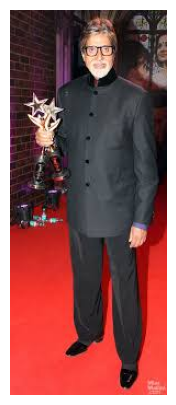

In [84]:
import matplotlib.pyplot as plt
from PIL import Image

def display_image(image_path):
    img = Image.open(image_path)

    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(img)

    plt.show()

image_path = top_matches[0]['image_path']
display_image(image_path)


# Dress style classification

In [65]:
dress_classifier_image_size = (224, 224)
dress_style_embedding_model, dress_style_classifier = load_model('/content/dress_style_vgg_model.h5')

In [79]:
classes = {
            0 : 'Anarkali',
            1 : 'Churidar',
            2 : 'Dhoti',
            3 : 'Lehenga',
            4 : 'Nehru Jacket',
            5 : 'Saree',
            6 : 'Sherwani'
          }

In [80]:
def predict_dress_style(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=dress_classifier_image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.

    predicts = dress_style_classifier.predict(img_array)

    top_3_indices = np.argsort(predicts[0])[::-1][:3]
    top_3_classes = [classes[i] for i in top_3_indices]
    top_3_probs = [predicts[0][i] for i in top_3_indices]

    return list(zip(top_3_classes, top_3_probs))

In [81]:
input_image_path = top_matches[0]['image_path']
predict_dress_style(input_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


[('Sherwani', 0.22696872), ('Churidar', 0.19108102), ('Lehenga', 0.18122293)]